# Import statements

In [1]:
# Operating System
import os

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

from sklearn.model_selection import train_test_split

from sklearn.pipeline import  Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin, BaseEstimator

import category_encoders as ce
from sklearn.preprocessing import KBinsDiscretizer, Binarizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.impute import SimpleImputer

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix


#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import binom_test

# Strings
import re

# Define utility functions

In [2]:
def simple_clean(doc, regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")] ):
    
    # Make sure it is a string!
    doc = str(doc)
    
    # remove or replace characters
    for regex in regex_list:
        doc = re.sub(regex[0], regex[1], doc)
    # lowercase
    doc = doc.lower()
    # Trim
    doc = doc.strip()
    # tokenize
    #words = tokenizer.tokenize(doc)
    # remove punctuation
    #words = list(filter(lambda x: x not in string.punctuation, words))
    # stem
    #stems = list(map(stemmer.stem, words))
    #new_doc = " ".join(stems)
    new_doc = doc
    return new_doc

# Load original data

In [3]:
file_path = os.path.join('data', 'train.csv')

# Option for reading a sample of the file
# sample 20% of the rows
p = 1

random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change
try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0, 
                             #nrows = 10000, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    # Drop observations correspoding to stops that didn't lead to a search
    df = df_original[df_original.VehicleSearchedIndicator==True].reset_index(drop=True).drop(columns='VehicleSearchedIndicator')


# Train-Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='ContrabandIndicator'), 
                                                    df['ContrabandIndicator'], 
                                                    test_size=0.6, 
                                                    random_state=42)

# Pre-process 

Both the train set and the test set will enter this pre-processing to prepare for fits ans transforms:
* Select columns to keep;
* Clean text features;

In [5]:
def pre_process_data(df: pd.DataFrame) -> pd.DataFrame:
    
    """Transforms the original DataFrame to make it suited to enter the workflow.
    
    Args:
        df (pd.DataFrame):  Original DataFrame, it will be first X_train and then X_test.
        
    Returns:
        df_new (pd.DataFrame): Transformed DataFrame, ready to enter the workflow.
        
    TODO:
        * to do list
        
    """
    
    columns_to_keep = ['Department Name', 'SearchAuthorizationCode', 'StatuteReason', 'SubjectAge']
    
    #columns_to_keep = ['Department Name', 'SearchAuthorizationCode','StatuteReason', 'SubjectAge', 'ResidentIndicator']

    #     columns_to_keep = ['Department Name', 
#                        'InterventionReasonCode',
#                        'ResidentIndicator', 
#                        'SearchAuthorizationCode', 
#                        'StatuteReason', 
#                        'SubjectAge', 
#                        'SubjectEthnicityCode', 
#                        'SubjectRaceCode', 
#                        'SubjectSexCode'
#                        ]
    
    # copy the argument
    df_new = df.copy()
    
    df_new = df_new[columns_to_keep]
    
    # Clean text features
    #df_new['Department Name'] = df_new['Department Name'].apply(simple_clean)
    #df_new['SearchAuthorizationCode'] = df_new['SearchAuthorizationCode'].apply(simple_clean)
    #df_new['StatuteReason'] = df_new['StatuteReason'].apply(simple_clean)
    
    
    return df_new

# Code workflow

In [6]:
# Initializations

decision_thr = 0.5

ordinalencoder = ce.ordinal.OrdinalEncoder()
#binarizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
binarizer = Binarizer(threshold=27)
clf = RandomForestClassifier(random_state = 42)


X_train_cln = pre_process_data(X_train)
X_train_cln = ordinalencoder.fit_transform(X_train_cln)
X_train_cln['SubjectAge'] = binarizer.fit_transform(X_train_cln[['SubjectAge']])
clf.fit(X_train_cln, y_train)


X_test_cln = pre_process_data(X_test)
X_test_cln = ordinalencoder.fit_transform(X_test_cln)
X_test_cln['SubjectAge'] = binarizer.fit_transform(X_test_cln[['SubjectAge']])

#y_pred = clf.predict(X_test_cln)
y_prob = clf.predict_proba(X_test_cln)[:,1]
y_pred = y_prob > decision_thr


C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Pipeline workflow

In [7]:
# Custom transformer to implement sentence cleaning
class TextCleanerTransformer(TransformerMixin):
    def __init__(self, 
                 regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")], 
                 lower=True, 
                 remove_punct=True):
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        #X = list(map(self._clean_sentence, X.values))
        X_copy = X.copy()
        X_copy = X_copy.applymap(self._clean_sentence)
        return X_copy
    
    def _clean_sentence(self, sentence):
        
        # Make sure it is a string!
        sentence = str(sentence)
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0], regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()
        
        # Trim
        sentence = sentence.strip()
        
        return sentence
    
    def fit(self, *_):
        return self

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 38894 to 15795
Data columns (total 13 columns):
Department Name                     30697 non-null object
InterventionDateTime                30697 non-null object
InterventionLocationName            30693 non-null object
InterventionReasonCode              30697 non-null object
ReportingOfficerIdentificationID    30697 non-null object
ResidentIndicator                   30697 non-null bool
SearchAuthorizationCode             30691 non-null object
StatuteReason                       30693 non-null object
SubjectAge                          30697 non-null float64
SubjectEthnicityCode                30697 non-null object
SubjectRaceCode                     30697 non-null object
SubjectSexCode                      30697 non-null object
TownResidentIndicator               30697 non-null bool
dtypes: bool(2), float64(1), object(10)
memory usage: 2.9+ MB


In [9]:
# X_train.InterventionDateTime.dt.hour

In [10]:
# X_copy = X_train[['InterventionDateTime']].applymap(pd.to_datetime)

In [11]:
# X_copy.head(10)

In [12]:
# pd.hourofday()

In [13]:
# X_copy2 = X_copy.applymap(dt.hour)

In [14]:
# Custom transformer to binarize the hour of the day into low (0) and high (1) finding rate hours
class HourOfDayTransformer(TransformerMixin):
    
    def __init__(self, high_rate_hours=[]):
        self.high_rate_hours = high_rate_hours        
        
    def transform(self, X, *_):
        #X = list(map(self._clean_sentence, X.values))
        X_copy = X.copy()
        
        X_copy = X_copy.applymap(pd.to_datetime)
        
        df.date = pd.to_datetime(df.date)
        
        
        
        X_copy = X_copy.applymap(self._binarize_hours)
        return X_copy
    
    def _binarize_hours(self):
        
        # Make sure it is a string!
        sentence = str(sentence)
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0], regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()
        
        # Trim
        sentence = sentence.strip()
        
        return sentence
    
    def fit(self, *_):
        return self

In [15]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[self.key]

    
class BoolSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[self.key]

### Save these one:

In [16]:
# text_pipe = Pipeline([
#                 ('selector', TextSelector(['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])),
#                 ('ordinalencoder', ce.ordinal.OrdinalEncoder())
#             ])

# numerical_pipe =  Pipeline([
#                 ('selector', NumberSelector(['SubjectAge'])),
#                 ('binarizer', Binarizer(threshold=27))
#             ])

# # Feature Union allow use to use multiple distinct features in our classifier
# feats = FeatureUnion([('text', text_pipe), 
#                       ('numerical', numerical_pipe)])

# pipe_clf = Pipeline([
#     ('features',feats),
#     ('classifier', RandomForestClassifier(random_state = 42)),
# ])

In [17]:
# # text_pipe = Pipeline([
# #                 ('selector', TextSelector(['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])),
# #                 ('cleaner', TextCleanerTransformer()),
# #                 ('ordinalencoder', ce.ordinal.OrdinalEncoder())
# #             ])

# text_pipe = Pipeline([
#                 ('selector', TextSelector(['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])),
#                 ('ordinalencoder', ce.ordinal.OrdinalEncoder())
#             ])

# # numerical_pipe =  Pipeline([
# #                 ('selector', NumberSelector(['SubjectAge'])),
# #                 ('binarizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'))
# #             ])

# numerical_pipe =  Pipeline([
#                 ('selector', NumberSelector(['SubjectAge'])),
#                 ('binarizer', Binarizer(threshold=27))
#             ])


# bool_pipe =  Pipeline([
#                 ('selector', BoolSelector(['ResidentIndicator']))                
#             ])

# # Feature Union allow use to use multiple distinct features in our classifier
# feats = FeatureUnion([('text', text_pipe), 
#                       ('numerical', numerical_pipe)])

# #feats = FeatureUnion([('text', text_pipe)])

# # feats = FeatureUnion([('text', text_pipe), 
# #                       ('numerical', numerical_pipe),
# #                       ('bool', bool_pipe)])

# pipe_clf = Pipeline([
#     ('features',feats),
#     ('classifier', RandomForestClassifier(random_state = 42)),
# ])

In [18]:
text_pipe = Pipeline([
                ('selector', TextSelector(['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])),
                ('ordinalencoder', ce.ordinal.OrdinalEncoder()),
                ('handle_unknown_imputer', SimpleImputer(missing_values=-1, strategy='most_frequent')),
                ('handle_missing_imputer1', SimpleImputer(missing_values=-2, strategy='most_frequent')),
            ])

numerical_pipe =  Pipeline([
                ('selector', NumberSelector(['SubjectAge'])),
                ('binarizer', Binarizer(threshold=27)),
                ('handle_missing_imputer1', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
            ])

# Feature Union allow use to use multiple distinct features in our classifier
feats = FeatureUnion([('text', text_pipe), 
                      ('numerical', numerical_pipe)])

pipe_clf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [19]:
pipe_clf.fit(X_train, y_train)

y_prob_pipe = pipe_clf.predict_proba(X_test)[:,1]
y_pred_pipe = y_prob_pipe > decision_thr

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Save model results for later perfromance evaluation.

In [20]:
(X_test.join(pd.DataFrame({'y_prob': y_prob_pipe,
                           'y_pred': y_pred_pipe,
                           'y_true': y_test})
                         .astype({'y_pred': 'int', 'y_true':'int'}))
        .reset_index(drop=True)
        .to_csv(os.path.join('data', 'test_set_performance.csv'), index=False))

In [21]:
X_test.shape

(46046, 13)

### Validate pipeline results

In [22]:
np.absolute(y_prob - y_prob_pipe).sum()

1.3236635644154011

In [23]:
(y_pred != y_pred_pipe).sum()

1

In [24]:
X_test[y_pred != y_prob_pipe]

,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
30717,CSP Headquarters,01/19/2016 05:11:05 PM,COLCHESTER,V,58211300,True,C,STC Violation,48.0,N,B,F,False
44889,Farmington,12/01/2016 11:21:00 AM,FARMINGTON,V,341,True,O,Registration,22.0,N,W,F,False
13938,Glastonbury,07/23/2014 12:21:00 AM,GLASTONBURY,E,JSG0383,True,C,Defective Lights,26.0,N,W,M,False
20220,New London,11/26/2014 12:56:00 AM,NEW LONDON,V,PSC56033,True,O,Defective Lights,35.0,N,A,M,False
21837,Watertown,01/01/2015 07:00:00 PM,WATERTOWN,V,1177,True,O,Other/Error,20.0,H,W,M,True
72386,Derby,03/30/2018 07:16:00 PM,Derby,V,061,True,O,Administrative Offense,61.0,N,B,F,False
28592,CSP Troop E,12/05/2015 09:11:28 AM,NORTH STONINGTON,V,1000002621,False,C,Speed Related,19.0,N,W,M,False
52567,Waterford,04/25/2017 01:18:00 AM,Waterford,V,73,True,O,Speed Related,22.0,N,B,F,False
73072,West Hartford,04/07/2018 01:36:00 PM,WEST HARTFORD,E,1000002072,True,O,Window Tint,30.0,N,B,M,False
41804,Manchester,09/16/2016 08:21:00 AM,Manchester,V,SEB5062,True,O,Speed Related,26.0,N,B,M,False


# Metrics

In [25]:
y_true = y_test

In [26]:
precision = precision_score(y_test, y_pred)
precision

0.5998483699772555

In [27]:
recall = recall_score(y_test, y_pred)
recall

0.514367442465219

In [28]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7231464187985928

In [29]:
cf = confusion_matrix(y_test, y_pred)
TN = cf[0][0]
TP = cf[1][1]
FN = cf[1][0]
FP = cf[0][1]

Sanity checks:

In [30]:
precision == TP/(TP+FP) 

True

In [31]:
recall == TP/(TP+FN)

True

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.83      0.80     30664
        True       0.60      0.51      0.55     15382

   micro avg       0.72      0.72      0.72     46046
   macro avg       0.69      0.67      0.68     46046
weighted avg       0.71      0.72      0.72     46046



In [33]:
y_pred.sum()/y_pred.shape[0]

0.2864526777570256

In [34]:
y_true.sum()

15382

# Curves

In [35]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
AUROC = roc_auc_score(y_test, y_prob)*100

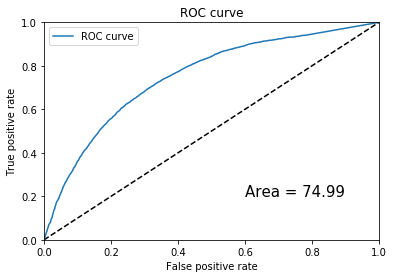

In [36]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC,2)), dict(size=15))

plt.legend(loc='best')
plt.show()

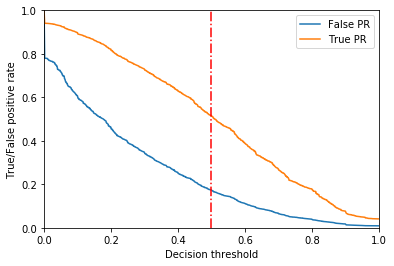

In [37]:
plt.figure(2)
plt.plot(thresholds_roc, fpr , label='False PR')
plt.plot(thresholds_roc, tpr, label='True PR')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
#plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [38]:
precision_vec, recall_vec, thresholds_pr = precision_recall_curve(y_test, y_prob)

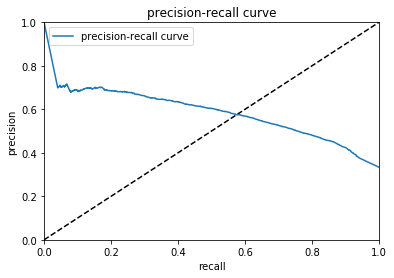

In [39]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_vec, precision_vec, label='precision-recall curve')

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

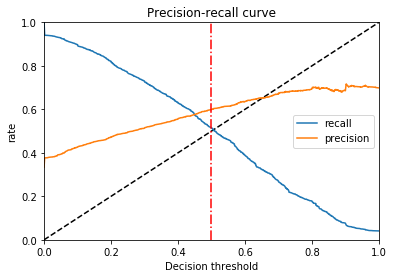

In [40]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(thresholds_pr, recall_vec[:-1] , label='recall')
plt.plot(thresholds_pr, precision_vec[:-1], label='precision')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('rate')
plt.title('Precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [41]:
df_results = y_test.to_frame(name='y_true')
df_results['y_pred'] = y_pred
df_results['y_prob'] = y_prob
df_results.head()

,y_true,y_pred,y_prob
30717,False,False,0.355556
44889,True,True,0.842211
13938,False,False,0.308561
20220,False,False,0.458966
21837,True,True,0.708333


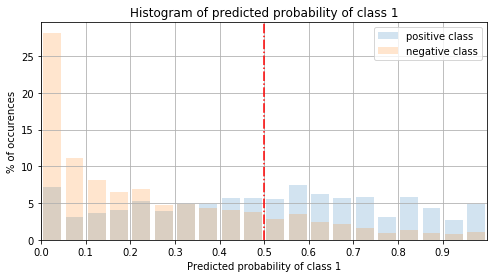

In [42]:
n_trues = df_results[df_results.y_true==True].shape[0]
n_falses = df_results[df_results.y_true==False].shape[0]

plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, weights=np.ones(n_trues)/n_trues*100, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, weights=np.ones(n_falses)/n_falses*100, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("% of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

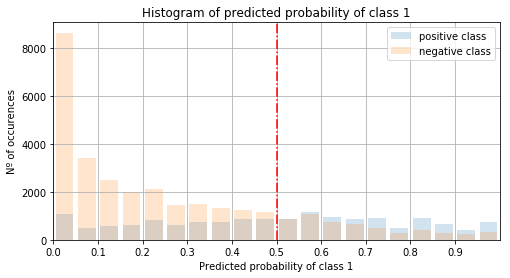

In [43]:
plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("Nº of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

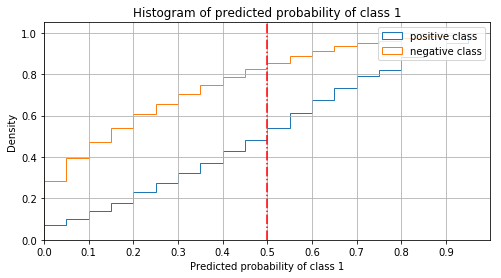

In [44]:
df_results[df_results.y_true==True].y_prob.hist(bins=20, figsize=(8,4), histtype='step',label='positive class', density=True, cumulative=True)
df_results[df_results.y_true==False].y_prob.hist(bins=20, figsize=(8,4), histtype='step', label='negative class', density=True, cumulative=True)

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("Density")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

In [45]:
df_results.set_index('y_prob').y_true

y_prob
0.355556    False
0.842211     True
0.308561    False
0.458966    False
0.708333     True
0.000000    False
0.057460    False
0.282269    False
0.344168    False
0.804051     True
0.000000    False
0.000000    False
0.433900     True
0.000000    False
0.416667     True
0.479296    False
0.204195    False
0.097471    False
0.000000    False
0.766692     True
0.537499     True
0.000000    False
0.403660    False
0.430556     True
0.200000    False
0.094979    False
0.576674    False
0.255201    False
0.833023     True
0.181569    False
            ...  
0.897500     True
0.000000    False
0.262657    False
0.000000    False
0.514135     True
0.291190    False
0.246688     True
0.283333    False
0.215925     True
0.300400    False
0.200000     True
0.576667     True
0.886763     True
0.510183    False
0.509524    False
0.255833     True
0.833023     True
0.032282    False
0.000000    False
0.214286    False
0.000000    False
0.160128    False
0.000000    False
0.630493     True
0.7

### Predict all `True`

In [46]:
y_pred_true = np.ones(y_test.shape).astype(bool)

In [47]:
precision_score(y_test, y_pred_true)

0.3340572471007254

In [48]:
recall_score(y_test, y_pred_true)

1.0

In [49]:
accuracy_score(y_test, y_pred_true)

0.3340572471007254

### Predict all `False`

In [50]:
y_pred_false = np.zeros(y_test.shape).astype(bool)

In [51]:
precision_score(y_test, y_pred_false)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [52]:
recall_score(y_test, y_pred_false)

0.0

In [53]:
accuracy_score(y_test, y_pred_false)

0.6659427528992746

### Predict randomly with positive\negative ratio `r`

In [54]:
np.random.seed(425)
ratio = 0.10

In [55]:
# y_pred_rand = np.random.randint(2, size=y_test.shape).astype(bool)
y_pred_rand = np.random.binomial(n=1, p=ratio, size=y_test.shape).astype(bool)

Percentage of searches

In [56]:
y_pred_rand.sum()/y_pred_rand.shape[0]

0.09946575163966469

In [57]:
precision_score(y_test, y_pred_rand)

0.3299126637554585

In [58]:
recall_score(y_test, y_pred_rand)

0.09823169938889612

In [59]:
accuracy_score(y_test, y_pred_rand)

0.6321070234113713

# Metrics among protected classes

In [60]:
df_test_classes = pd.DataFrame({X_test.SubjectRaceCode.name: X_test.SubjectRaceCode, 
                                X_test.SubjectEthnicityCode.name: X_test.SubjectEthnicityCode, 
                                X_test.SubjectSexCode.name: X_test.SubjectSexCode, 
                                'y_true': y_true, 
                                'y_pred': y_pred})

In [61]:
#sanity check
df_test_classes.shape[0] == X_test.shape[0]

True

In [62]:
test_race_results = df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
test_ethnic_results = df_test_classes.groupby(['SubjectEthnicityCode','y_true', 'y_pred']).SubjectEthnicityCode.count()
test_sex_results = df_test_classes.groupby(['SubjectSexCode','y_true', 'y_pred']).SubjectSexCode.count()

Sanity checks:

In [63]:
test_race_results[:,True,:].sum() == test_ethnic_results[:,True,:].sum() == test_sex_results[:,True,:].sum() == y_true.sum()

True

In [64]:
test_race_results[:,:,True].sum() == test_ethnic_results[:,:,True].sum() == test_sex_results[:,:,True].sum() == y_pred.sum()

True

In [65]:
df_test_classes.head(10)

,SubjectRaceCode,SubjectEthnicityCode,SubjectSexCode,y_true,y_pred
30717,B,N,F,False,False
44889,W,N,F,True,True
13938,W,N,M,False,False
20220,A,N,M,False,False
21837,W,H,M,True,True
54524,W,H,M,False,False
72386,B,N,F,False,False
28592,W,N,M,False,False
52567,B,N,F,False,False
73072,B,N,M,True,True


### Precision overall

In [66]:
precision_score(y_true, y_pred)

0.5998483699772555

In [67]:
# Sanity check
df_test_classes[df_test_classes.y_pred==True].y_true.mean()

0.5998483699772555

### Precision among races

Precision table:

In [68]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100)

SubjectRaceCode
A    54.761905
B    54.816450
I    65.714286
W    61.991956
Name: y_true, dtype: float64

Max. difference:

In [69]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().max() - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().min())*100

10.952380952380947

Max. difference [%]:

In [70]:
(1 - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().min() / df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().max())*100

16.666666666666664

In [71]:
1-93/99

0.06060606060606055

Standard difference:

In [72]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100).std()

5.449294263666403

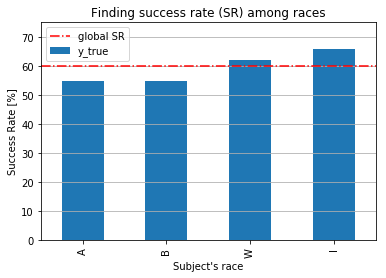

In [73]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among ethnicities

When the classifier predicts positive, it is more sure about the prediction for Whites than for Blacks.

Precision table:

In [74]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)

SubjectEthnicityCode
H    57.643814
M    50.000000
N    60.642532
Name: y_true, dtype: float64

Max. difference:

In [75]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().max() - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().min())*100

10.642532221379831

Max. difference [%]:

In [76]:
(1 - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().min() / df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().max())*100

17.5496171276762

Standard difference:

In [77]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100).std()

5.4876178160450335

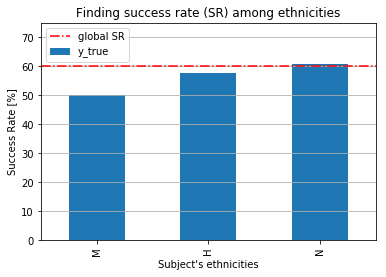

In [78]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among ethnicities')
plt.xlabel("Subject's ethnicities")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among sexes

Precision table:

In [79]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)

SubjectSexCode
F    61.132075
M    59.731606
Name: y_true, dtype: float64

Max. difference [p.p.]:

In [80]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().max() - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().min())*100

1.400469733613885

Max. difference [%]:

In [81]:
(1 - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().min() / df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().max())*100

2.290891848195553

Standard difference:

In [82]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100).std()

0.9902816454848937

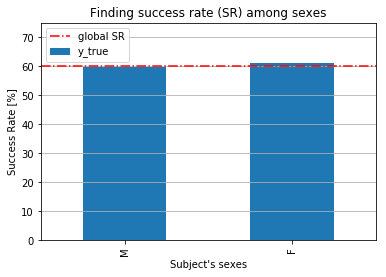

In [83]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among sexes')
plt.xlabel("Subject's sexes")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Recall overall

In [84]:
recall_score(y_true, y_pred)

0.514367442465219

In [85]:
# Sanity check
df_test_classes[df_test_classes.y_true==True].y_pred.mean()

0.514367442465219

In [86]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectRaceCode').y_pred.mean()

SubjectRaceCode
A    0.522727
B    0.491341
I    0.547619
W    0.522480
Name: y_pred, dtype: float64

In [87]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectEthnicityCode').y_pred.mean()

SubjectEthnicityCode
H    0.497281
M    0.318471
N    0.520964
Name: y_pred, dtype: float64

In [88]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectSexCode').y_pred.mean()

SubjectSexCode
F    0.534066
M    0.510117
Name: y_pred, dtype: float64

In [89]:
df_test_classes.groupby('SubjectRaceCode')[['y_true', 'y_pred']]

In [90]:
df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred'])[['y_true', 'y_pred']]

In [91]:
test_race_results

SubjectRaceCode  y_true  y_pred
A                False   False       180
                         True         38
                 True    False        42
                         True         46
B                False   False      7856
                         True       1637
                 True    False      2056
                         True       1986
I                False   False        79
                         True         12
                 True    False        19
                         True         23
W                False   False     17271
                         True       3591
                 True    False      5353
                         True       5857
Name: SubjectRaceCode, dtype: int64

In [92]:
test_race_results.loc[:,:,True]

SubjectRaceCode  y_true
A                False       38
                 True        46
B                False     1637
                 True      1986
I                False       12
                 True        23
W                False     3591
                 True      5857
Name: SubjectRaceCode, dtype: int64

### Precision by class

In [93]:
test_race_results = df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
test_race_results

SubjectRaceCode  y_true  y_pred
A                False   False       180
                         True         38
                 True    False        42
                         True         46
B                False   False      7856
                         True       1637
                 True    False      2056
                         True       1986
I                False   False        79
                         True         12
                 True    False        19
                         True         23
W                False   False     17271
                         True       3591
                 True    False      5353
                         True       5857
Name: SubjectRaceCode, dtype: int64

In [94]:
test_race_results.loc[:,False,:]

SubjectRaceCode  y_pred
A                False       180
                 True         38
B                False      7856
                 True       1637
I                False        79
                 True         12
W                False     17271
                 True       3591
Name: SubjectRaceCode, dtype: int64

In [95]:
# sanity check
df_test_race.y_true.sum() == y_test.sum() and df_test_race.y_pred.sum() == y_pred.sum()

NameError: name 'df_test_race' is not defined

In [ ]:
df_test_race.y_true.sum()

In [ ]:
y_test.sum()

In [ ]:
recall = recall_score(y_test, y_pred)
recall

In [ ]:
df_test_classes = pd.DataFrame({X_test.SubjectRaceCode.name: X_test.SubjectRaceCode, 
                                X_test.SubjectEthnicityCode.name: X_test.SubjectEthnicityCode, 
                                X_test.SubjectSexCode.name: X_test.SubjectSexCode, 
                                'y_true': y_test ,
                                'y_pred': y_pred})
df_test_classes

In [ ]:
5278/(5278+7912)

In [ ]:
confusion_matrix(y_test, y_pred)